# Spark

In [1]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libxtst6 amd64 2:1.2.3-1 [12.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 openjdk-8-jre-headless amd64 8u372-ga~us1-0ubuntu1~20.04 [28.3 MB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 openjdk-8-jdk-headless amd64 8u372-ga~us1-0ubuntu1~20.04 [8,282 kB]
Fetched 

In [2]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2023-05-19 03:57:16--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M   245KB/s    in 20m 55s 

2023-05-19 04:18:11 (212 KB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [3]:
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

In [4]:
!pip install -q findspark

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [6]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [8]:
spark

In [9]:
pip install gmplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.7/164.7 kB 5.8 MB/s eta 0:00:00


# EDA

In [10]:
#importing essential libraries
import pyspark.sql
import datetime
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
import pyspark
import numpy as np
import pandas as pd
import pyspark.ml.feature
import pyspark.ml.classification 
import pyspark.ml.evaluation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LinearSVC
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import NaiveBayes 
from geopy.geocoders import Nominatim
import numpy as np
import gmplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
import os
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
import webbrowser

In [11]:
#Loading datasets into spark
DF_LevelEvents = spark.read.csv("/content/level-events.csv", header=True, inferSchema=True)
DF_GameClicks = spark.read.csv("/content/game-clicks.csv", header=True, inferSchema=True)
DF_BuyClicks = spark.read.csv("/content/buy-clicks.csv", header=True, inferSchema=True)
DF_AdClicks = spark.read.csv("/content/ad-clicks.csv", header=True, inferSchema=True)
DF_Users = spark.read.csv("/content/users.csv", header=True, inferSchema=True)
DF_UserSession = spark.read.csv("/content/user-session.csv", header=True, inferSchema=True)
DF_Team = spark.read.csv("/content/team.csv", header=True, inferSchema=True)
DF_TeamAssignment = spark.read.csv("/content/team-assignments.csv", header=True, inferSchema=True)


In [12]:
#remove all rows with missing values
DF_Users = DF_Users.na.drop()
DF_UserSession = DF_UserSession.na.drop()
DF_Team = DF_Team.na.drop()
DF_TeamAssignment = DF_TeamAssignment.na.drop()
DF_LevelEvents = DF_LevelEvents.na.drop()
DF_GameClicks = DF_GameClicks.na.drop()
DF_BuyClicks = DF_BuyClicks.na.drop()
DF_AdClicks = DF_AdClicks.na.drop()

In [13]:
from pyspark.sql.functions import col, when, floor, datediff
from datetime import date

# Calculate age from date of birth
today = date.today()
DF_Users = DF_Users.withColumn('age', floor(datediff(lit(today), 'dob') / 365.25))

# Define age group conditions
age_group_conditions = [(col('age').between(i, i+9), f'{i}-{i+9}') for i in range(0, 100, 10)]

# Apply age group conditions
age_group_expression = when(age_group_conditions[0][0], age_group_conditions[0][1])
for condition, group in age_group_conditions[1:]:
    age_group_expression = age_group_expression.when(condition, group)

# Add 'age_group' column to DF_Users
DF_Users = DF_Users.withColumn('age_group', age_group_expression.otherwise(None))

DF_Users = DF_Users.drop('dob')
# Show the resulting DataFrame
DF_Users.show()


+-------------------+------+-----------+----------+-------+---+---------+
|          timestamp|userId|       nick|   twitter|country|age|age_group|
+-------------------+------+-----------+----------+-------+---+---------+
|2012-06-19 14:53:41|   442|   pcjIOBKW|  @SZhyOHv|     BA| 28|    20-29|
|2012-06-19 19:29:01|   949|    vAOfUkf|    @nkkNo|     HU| 52|    50-59|
|2012-06-20 19:34:59|  1654|     qOOXSQ|    @SwOlw|     IS| 53|    50-59|
|2012-06-21 01:18:29|  1586|    px4gW51|  @IrCHTnE|     AM| 57|    50-59|
|2012-06-21 15:35:00|   599|9gkfwRC73Uc|   @VJj0Az|     CC| 28|    20-29|
|2012-06-22 11:36:19|   952| BRbb3VOTti|   @b4OK6K|     MH| 36|    30-39|
|2012-06-23 08:11:18|  1056|    fGCIAtI| @IgDsdWdU|     SM| 31|    30-39|
|2012-06-23 10:54:19|    91|tpDfgi3S0N9|   @LvTHGO|     BZ| 45|    40-49|
|2012-06-23 14:59:26|   809| LkNRpRW6Ez|@ROrRkXwdh|     PF| 71|    70-79|
|2012-06-23 17:40:35|    75|     fNWewX|   @OXqLyv|     JO| 43|    40-49|
|2012-06-23 17:57:05|  2224|   rvXvUU9

**PLOTING DIFFERENT PLAYERS BELONGS TO DIFFERENT AGE GROUPS**

<ipython-input-15-12bf861cc5e5>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


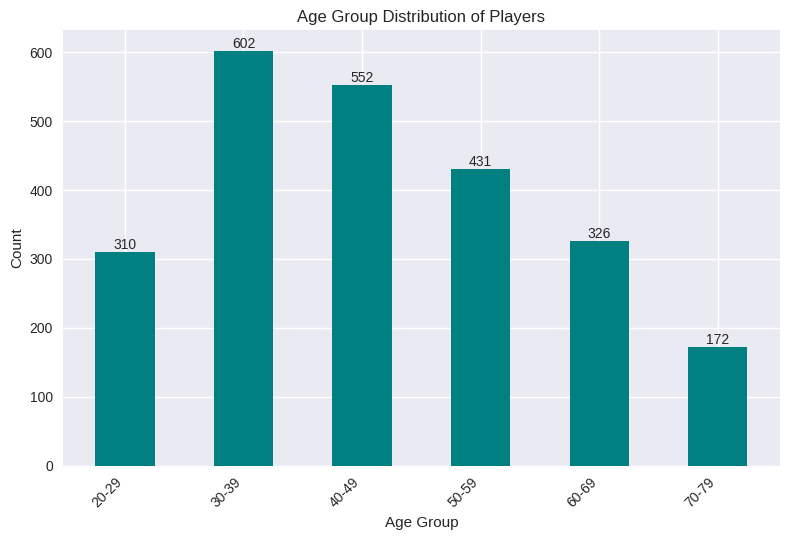

In [15]:

# Group the players by age group and count the number of players in each group
age_group_counts = DF_Users.groupBy('Age_Group').count().orderBy('Age_Group')

# Extract the age groups and count values from the DataFrame
age_groups = age_group_counts.select('age_group').rdd.flatMap(lambda x: x).collect()
counts = age_group_counts.select('count').rdd.flatMap(lambda x: x).collect()

# Create a bar plot with a modern style
plt.style.use('seaborn')

fig, ax = plt.subplots()
bar_width = 0.5

# Set the x positions of the bars
x_pos = np.arange(len(age_groups))

# Plot the bars
bars = ax.bar(x_pos, counts, bar_width, color='teal')

# Set the x-axis labels and tick positions
ax.set_xlabel('Age Group')
ax.set_ylabel('Count')
ax.set_title('Age Group Distribution of Players')
ax.set_xticks(x_pos)
ax.set_xticklabels(age_groups)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()



In [16]:
DF_Users = DF_Users.drop('age_group')

In [17]:
#drop columns not needed from userSession.csv
DF_UserSession = DF_UserSession.drop('timestamp', 'userSessionId', 'assignmentId', 'sessionType', 'teamLevel')
#drop duplicates from userSession
DF_UserSession.dropDuplicates(['userId']).show()

+------+------+------------+
|userId|teamId|platformType|
+------+------+------------+
|     0|   157|      iphone|
|     1|    99|     android|
|     2|    22|      iphone|
|     6|    77|      iphone|
|     8|   124|      iphone|
|     9|    97|      iphone|
|    10|   131|       linux|
|    12|    66|      iphone|
|    13|    78|     android|
|    14|   104|       linux|
|    15|    74|     windows|
|    16|   113|     android|
|    17|    97|     android|
|    20|   120|      iphone|
|    21|     9|     android|
|    23|   103|     android|
|    25|    75|         mac|
|    26|   173|     windows|
|    27|    70|         mac|
|    28|    64|      iphone|
+------+------+------------+
only showing top 20 rows



In [18]:
#join users.csv with userSession.csv
DF_New = DF_Users.join(DF_UserSession,["userId"])

In [19]:
DF_Team.show()

+------+-----------+-------------------+-------------------+---------------+------------+
|teamId|       name|   teamCreationTime|        teamEndTime|       strength|currentLevel|
+------+-----------+-------------------+-------------------+---------------+------------+
|    79|    O1uJX7C|2016-06-12 15:33:27|9999-12-31 23:59:59| 0.774473575316|           1|
|    92|   WeLHp8HZ|2016-06-12 21:54:20|9999-12-31 23:59:59|  0.17192602642|           1|
|     6|     mARlfz|2016-06-12 23:02:16|9999-12-31 23:59:59| 0.537353043526|           1|
|     7| xO41jlAo0Y|2016-06-13 06:03:03|9999-12-31 23:59:59| 0.394370370549|           1|
|    40|    vdwO0k1|2016-06-13 07:01:03|9999-12-31 23:59:59| 0.706832959169|           1|
|    18|  VpF5Lrtz7|2016-06-13 12:23:36|9999-12-31 23:59:59| 0.885469892018|           1|
|    91|  8brfgFZi6|2016-06-13 12:33:58|9999-12-31 23:59:59| 0.478092156292|           1|
|    90|  0sicoF7Pl|2016-06-13 13:06:10|9999-12-31 23:59:59| 0.443162418548|           1|
|    78| e

In [20]:
#add teamId and Strength to the new dataset
DF_Team = DF_Team.drop('name', 'teamCreationTime', 'teamEndTime', 'currentLevel')
DF_TeamP = DF_Team.toPandas()

In [21]:
DF_TeamP

,teamId,strength
0,79,0.774474
1,92,0.171926
2,6,0.537353
3,7,0.394370
4,40,0.706833
...,...,...
104,143,0.060460
105,161,0.994851
106,165,0.073988
107,171,0.225849


In [22]:
DF_NewP = DF_New.toPandas()

In [23]:
#add teamId and Strength to the new dataset
CurrentDF = pd.merge(DF_NewP, DF_TeamP, how='outer', suffixes=('', '_drop'))

In [ ]:
CurrentDF

In [25]:
#combine the newest dataset with isHit and ClickID
DF_Game = pd.read_csv ('/content/game-clicks.csv')
DF_Game = DF_Game.rename(columns=lambda x: x.strip()) #removes whitespaces from headers if exists
DF_Game = DF_Game.groupby(['userId'],as_index=False).agg({'isHit':'sum', 'clickId':'count'})
DF_Combined = pd.merge(CurrentDF, DF_Game, how='outer', suffixes=('', '_drop'))

In [26]:
#insert price and buyid from the buy-clicks file to DF-combined

DF_BuyClicks = pd.read_csv ('/content/buy-clicks.csv')
DF_BuyClicks = DF_BuyClicks.groupby(['userId'],as_index=False).agg({'price':'sum', 'buyId':'count'})

DF = pd.merge(DF_Combined, DF_BuyClicks, how='outer', suffixes=('', '_drop'))

In [27]:
#combine the add clicks file
DF_AdClick = pd.read_csv ('/content/ad-clicks.csv')
DF_AdClick = DF_AdClick.groupby(['userId'],as_index=False).agg({'adId':'count'})

DF = pd.merge(DF, DF_AdClick, how='outer', suffixes=('', '_drop'))

In [28]:
#Drop the duplicate columns
DF.drop([col for col in DF.columns if 'drop' in col], axis=1, inplace=True)

DF = DF[DF['userId'].notna()]

In [ ]:
#view new dataset
DF.head()

In [30]:
#rename the final DF data columns
DF = DF.rename(columns={'price': 'total_purchases_amount',
                                                'clickId': 'game_clicks_count',
                                                'isHit': 'hit_count' ,
                                                'buyId': 'purchases_count',
                                                'adId': 'ad_clicks_count'
                                                })

In [31]:
#insert the bought_items column and set it to 1, where purchases_count > 0 
DF['bought_items'] = np.where(DF['purchases_count'] >= 1, 1, 0)

In [32]:
# delete redundant columns
del DF['nick']
del DF['twitter']

In [33]:
# replace NA Values:

DF['platformType']=DF['platformType'].fillna('No Platform')
DF['country']=DF['country'].fillna('No country')
DF['teamId']=DF['teamId'].fillna(0)
DF['strength']=DF['strength'].fillna(0)
DF['total_purchases_amount']=DF['total_purchases_amount'].fillna(0)
DF['purchases_count']=DF['purchases_count'].fillna(0)
DF['hit_count']=DF['hit_count'].fillna(0)
DF['game_clicks_count']=DF['game_clicks_count'].fillna(0)
DF['ad_clicks_count']=DF['ad_clicks_count'].fillna(0)
DF['age']=DF['ad_clicks_count'].fillna(0)
DF['timestamp']=DF['timestamp'].fillna(0)

In [34]:
# Changing data type from float to int for features that are Ids or counts features:
    
DF['teamId'] = DF['teamId'].astype('Int64')
DF['userId'] = DF['userId'].astype('Int64')
DF['purchases_count'] = DF['purchases_count'].astype('Int64')
DF['hit_count'] = DF['hit_count'].astype('Int64')
DF['game_clicks_count'] = DF['purchases_count'].astype('Int64')
DF['ad_clicks_count'] = DF['hit_count'].astype('Int64')
DF['age'] = DF['age'].astype('Int64')

In [ ]:
#show dataobjects
DF.isna().any()

In [36]:
#remove duplicate records
DF.duplicated(subset='userId').sum()
DF.shape

(9350, 13)

In [37]:
#drop duplicates
DF = DF.drop_duplicates(['userId']).reset_index(drop=True)

In [38]:
# remove instances of users who never interacted with the game at all
DF = DF.drop(DF[(DF['teamId'] == 0) & (DF['strength'] == 0) & (DF['game_clicks_count'] == 0) & (DF['purchases_count'] == 0)].index)
DF.shape 

(1108, 13)

In [39]:
# Check if there is a bias in the bought_items feature:
DF.groupby('bought_items')['userId'].count()

bought_items
0    562
1    546
Name: userId, dtype: int64

In [ ]:
#show users hit counts
HitCount = DF["hit_count"].value_counts()
HitCount = pd.DataFrame(HitCount)
HitCount

In [41]:
#showing the relationship between the platformType used by users to play the game
PlatformPlot = DF["platformType"].value_counts()
PlatformPlot = pd.DataFrame(PlatformPlot)
PlatformPlot

,platformType
iphone,444
android,391
windows,151
linux,55
mac,52
No Platform,15


**ACTIVITY COUNT ON DIFFERENT PLATFORM**

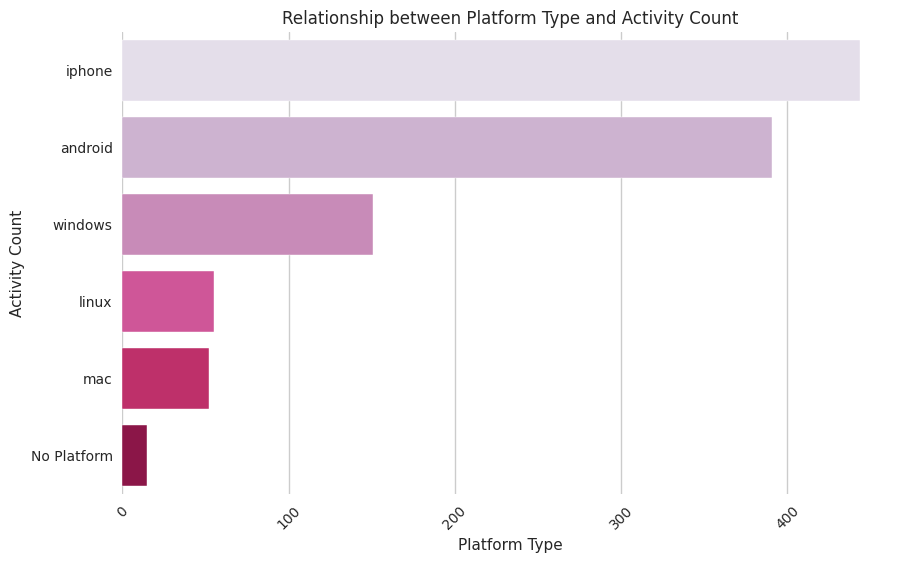

In [42]:

#Setting the style for a more modern look
sns.set_style("whitegrid")

#Plotting the relationship between platform type and activity count
plt.figure(figsize=(10, 6)) # Adjust the figure size as needed
sns.barplot(x="platformType", y=PlatformPlot.index, data=PlatformPlot, palette="PuRd")

#Customizing the plot
plt.xlabel("Platform Type")
plt.ylabel("Activity Count")
plt.title("Relationship between Platform Type and Activity Count")
plt.xticks(rotation=45) # Rotating x-axis labels if needed

#Removing the spines
sns.despine()

#Displaying the plot
plt.show()

**TOTAL PURCHASE COUNT USING DIFFERENT PLATFORM**

<Axes: xlabel='total_purchases_amount', ylabel='platformType'>

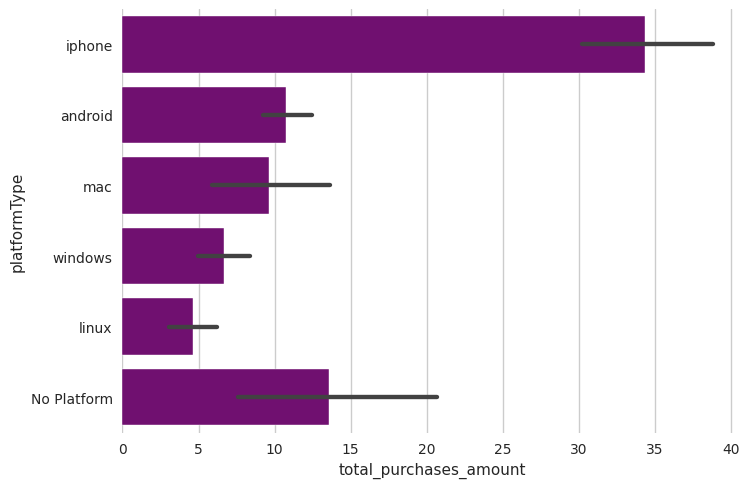

In [43]:
#Total Purchase count using different platforms
sns.barplot(x="total_purchases_amount", y="platformType", data=DF, color="purple")


**TOP 3 USERS WITH HIGHEST HITS**

In [ ]:
import pandas as pd

# Grouping the users by hit count and calculating the sum of userId
Hcount = DF.groupby('hit_count').sum()['userId'].sort_values(ascending=False)

# Creating a DataFrame from the Hcount series
table = pd.DataFrame({'Hit Count': Hcount.index, 'User Count': Hcount.values})




<ipython-input-46-bf4c772e64ce>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Hcount = DF.groupby('hit_count').sum()['userId'].sort_values(ascending=False)


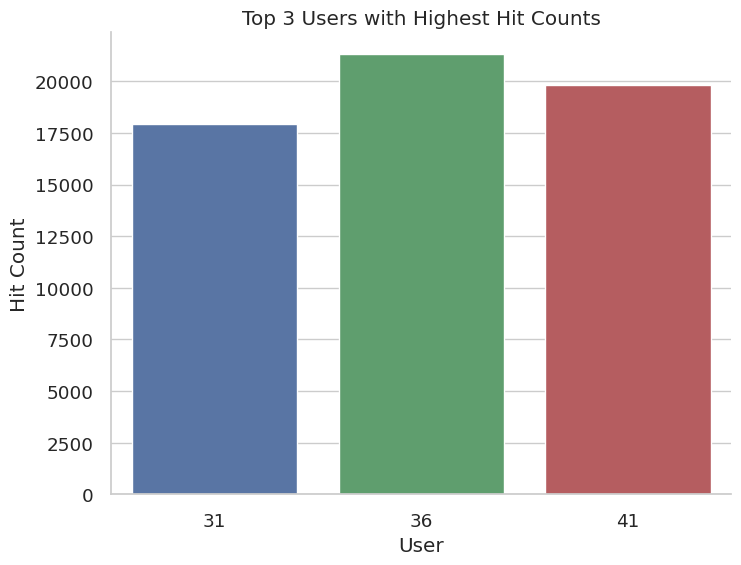

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

#Grouping the users by hit count and calculating the sum of userId
Hcount = DF.groupby('hit_count').sum()['userId'].sort_values(ascending=False)

#Selecting the top 3 users
top_users = Hcount.head(3)

#Setting the style for a more professional look
sns.set(style="whitegrid", font_scale=1.2)

#Defining a custom color palette
colors = ["#4c72b0", "#55a868", "#c44e52"]

#Plotting the top 3 users with the highest hit counts
plt.figure(figsize=(8, 6)) # Adjust the figure size as needed
sns.barplot(x=top_users.index, y=top_users.values, palette=colors)

#Customizing the plot
plt.xlabel("User")
plt.ylabel("Hit Count")
plt.title("Top 3 Users with Highest Hit Counts")

#Removing the spines
sns.despine()

#Displaying the plot
plt.show()

In [48]:
#show the data summary
showSummary = DF.describe()
showSummary = showSummary.T
showSummary

,count,mean,std,min,25%,50%,75%,max
userId,1108.0,1194.847473,692.33542,0.0,590.75,1195.0,1782.25,2389.0
age,1108.0,14.661552,18.02638,0.0,0.0,4.0,30.0,67.0
teamId,1108.0,79.798736,44.888018,0.0,44.0,77.0,116.0,179.0
strength,1108.0,0.33016,0.337253,0.0,0.0,0.237,0.6115,0.952176
hit_count,1108.0,74.758123,65.613519,1.0,31.0,59.0,95.0,517.0
game_clicks_count,1108.0,2.659747,3.533901,0.0,0.0,0.0,5.0,16.0
total_purchases_amount,1108.0,19.320397,34.905748,0.0,0.0,0.0,25.0,223.0
purchases_count,1108.0,2.659747,3.533901,0.0,0.0,0.0,5.0,16.0
ad_clicks_count,1108.0,74.758123,65.613519,1.0,31.0,59.0,95.0,517.0
bought_items,1108.0,0.49278,0.500174,0.0,0.0,0.0,1.0,1.0


In [49]:
plat_group = DF.groupby ('platformType').mean()
plat_group

<ipython-input-49-afba333b9796>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plat_group = DF.groupby ('platformType').mean()


,userId,age,teamId,strength,hit_count,game_clicks_count,total_purchases_amount,purchases_count,ad_clicks_count,bought_items
platformType,,,,,,,,,,
No Platform,1055.0,3.133333,0.0,0.000000,9.466667,1.466667,13.600000,1.466667,9.466667,1.000000
android,1215.826087,14.757033,82.117647,0.338865,75.749361,2.667519,10.772379,2.667519,75.749361,0.470588
iphone,1189.968468,14.768018,78.849099,0.346807,74.849099,2.61036,34.306306,2.61036,74.849099,0.486486
linux,1189.909091,18.4,84.854545,0.275721,92.545455,3.490909,4.636364,3.490909,92.545455,0.563636
mac,1165.980769,10.538462,85.519231,0.354300,66.538462,1.980769,9.634615,1.980769,66.538462,0.480769
windows,1180.503311,15.304636,80.701987,0.302983,74.761589,2.834437,6.642384,2.834437,74.761589,0.496689


**TOTAL ITEM PURCHASED BY EACH USER**

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 18.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 50.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


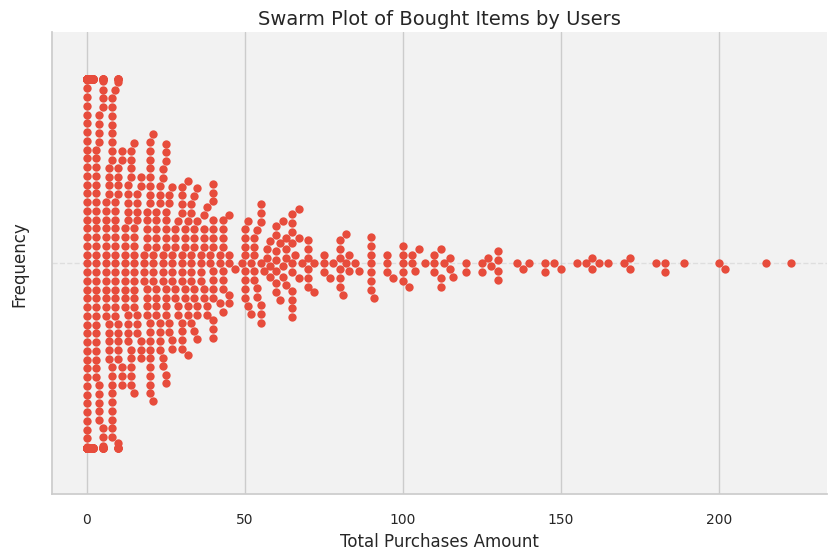

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

#Defining a custom color palette
colors = ['#E74C3C', '#3498DB', '#2ECC71']

#Setting the style and color palette for a more visually appealing plot
sns.set(style="whitegrid", palette=colors)

#Plotting the swarm plot of bought items by users
plt.figure(figsize=(10, 6)) # Adjust the figure size as needed
sns.swarmplot(data=DF, x="total_purchases_amount", size=6)

#Customizing the plot
plt.xlabel("Total Purchases Amount", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Swarm Plot of Bought Items by Users", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#Adding a horizontal grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

#Adding a background color for more contrast
plt.gca().set_facecolor('#f2f2f2')

#Removing the top and right spines
sns.despine(top=True, right=True)

#Displaying the plot with improved visual effects
plt.show()








**TOP 3 TEAMS WITH MOST USERS COUNT**

In [52]:
# Top teams with highest members
    
teams = DF.copy()
teams = teams[['teamId','userId']]
teams = teams[teams['teamId'].notna()]
teams = teams.groupby('teamId')['userId'].count().to_frame().reset_index()
teams = teams.rename(columns = {'userId':'users_count'})

# Drop instances from this data frame if team id = 0 which means the user has no team.
teams = teams[teams.teamId != 0]
teams["Percentage"] = 100*(teams["users_count"]/teams['users_count'].sum())
teams.sort_values(by='users_count', ascending=False, inplace=True)
teams=teams.reset_index(drop=True)
teams = teams.head(3)

<ipython-input-53-d506952e826c>:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(wedges, labels=teams["teamId"], loc="best")


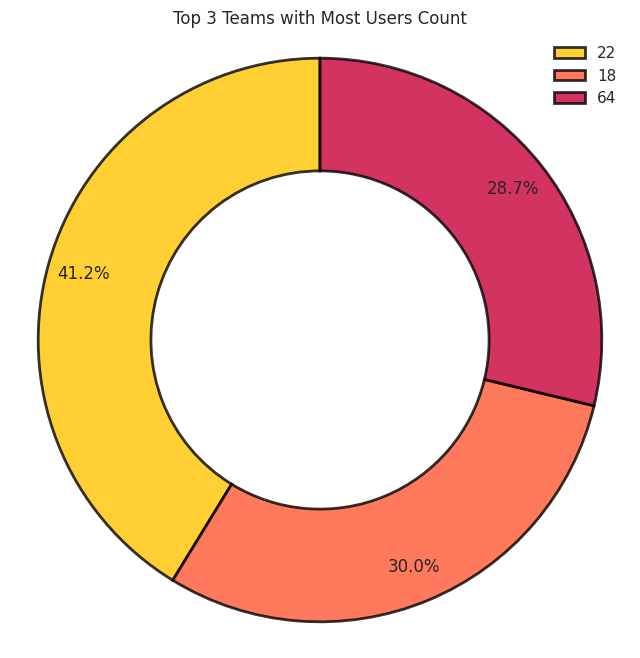

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the style for a more modern look
sns.set_style("whitegrid")

# Pie Chart for top 3 teams with most users count
custom_colors = ['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845']  # Define your custom colors
plt.figure(figsize=(8, 8)) # Adjust the figure size as needed

# Creating the pie chart with custom colors
wedges, _, _ = plt.pie(teams["users_count"], autopct='%1.1f%%', startangle=90, pctdistance=0.87, colors=custom_colors,
                       wedgeprops={"edgecolor": "black", "linewidth": 2, "alpha": 0.8})

# Adding legend and labels
plt.legend(wedges, labels=teams["teamId"], loc="best")
plt.axis('equal')

# Adding a title
plt.title("Top 3 Teams with Most Users Count")

# Customizing the design
plt.setp(wedges, width=0.4)  # Adjust the width of the wedges
plt.gca().add_artist(plt.Circle((0, 0), 0.3, color='white'))  # Add a white circle in the center for a donut-like effect

# Displaying the plot
plt.show()


In [57]:
# remove instances where users have no team
TopUsers = TopUsers[TopUsers.userId != 0]
TopUsers["Percentage"] = 100*(TopUsers["Total_Amount"]/TopUsers['Total_Amount'].sum())
TopUsers.sort_values(by='Total_Amount', ascending=False, inplace=True)
TopUsers=TopUsers.reset_index(drop=True)
TopUsers = TopUsers.head(10)

<ipython-input-57-83705fd5e5cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TopUsers["Percentage"] = 100*(TopUsers["Total_Amount"]/TopUsers['Total_Amount'].sum())
<ipython-input-57-83705fd5e5cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TopUsers.sort_values(by='Total_Amount', ascending=False, inplace=True)


# MACHINE LEARNING

**NAIVE BAYES**

In [58]:
#classification
#drop columns not needed for classification
DF.drop(['platformType', 'country', 'userId','timestamp'], axis=1, inplace=True)

In [59]:
#convert pandas dataframe to spark
DF = spark.createDataFrame(DF)

/content/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [60]:
DF = DF.withColumnRenamed("bought_items", "label")

In [61]:
#consolidate all of the predictor columns into a single column
# Create an assembler object
assembler = VectorAssembler(inputCols=[
    'age','teamId','strength', 'hit_count',
    'game_clicks_count', 
    'total_purchases_amount',
    'purchases_count', 'ad_clicks_count'
], outputCol='features')

# Consolidate predictor columns
df_assembled = assembler.transform(DF)

# Check the resulting column
df_assembled.show(5, truncate=False)

+---+------+--------------+---------+-----------------+----------------------+---------------+---------------+-----+------------------------------------------------------+
|age|teamId|strength      |hit_count|game_clicks_count|total_purchases_amount|purchases_count|ad_clicks_count|label|features                                              |
+---+------+--------------+---------+-----------------+----------------------+---------------+---------------+-----+------------------------------------------------------+
|1  |90    |0.443162418548|7        |0                |0.0                   |0              |7              |0    |[1.0,90.0,0.443162418548,7.0,0.0,0.0,0.0,7.0]         |
|0  |90    |0.443162418548|238      |0                |0.0                   |0              |238            |0    |(8,[1,2,3,7],[90.0,0.443162418548,238.0,238.0])       |
|53 |90    |0.443162418548|243      |9                |61.0                  |9              |243            |1    |[53.0,90.0,0.44316241854

In [63]:
train, test = df_assembled.randomSplit([0.8, 0.2], seed = 3000)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 902
Test Dataset Count: 206


In [64]:
nb = NaiveBayes(modelType="multinomial")

In [ ]:
nbmodel = nb.fit(train)
predictions_df = nbmodel.transform(test)
predictions_df.show(5, True)

In [66]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy") 
nbaccuracy = evaluator.evaluate(predictions_df) 
print("Test accuracy = " + str(nbaccuracy))

Test accuracy = 0.9563106796116505


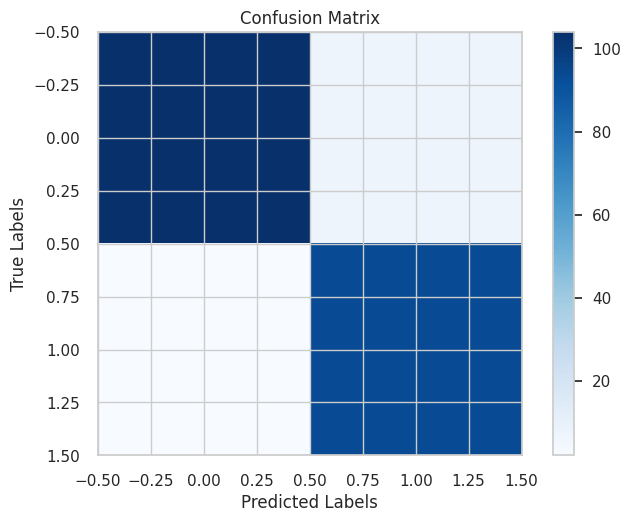

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

# Confusion Matrix
y_true = np.array(predictions_df.select('label').collect())
y_pred = np.array(predictions_df.select('prediction').collect())

confusion_mat = confusion_matrix(y_true, y_pred)
plt.imshow(confusion_mat, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**CLUSTERING**

In [68]:
#clustering
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pandas.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)


def elbow(elbowset, clusters):
	wsseList = []	
	for k in clusters:
		print("Training for cluster size {} ".format(k))
		kmeans = KM(k = k, seed = 1)
		model = kmeans.fit(elbowset)
		transformed = model.transform(elbowset)
		featuresAndPrediction = transformed.select("features", "prediction")

		W = computeCost(featuresAndPrediction, model)
		print("......................WSSE = {} ".format(W))

		wsseList.append(W)
	return wsseList

def elbow_plot(wsseList, clusters):
	wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
	wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

def parallel_plot(data, P):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(P)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [69]:
#Clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
featuresUsed = ['age','teamId','strength', 'hit_count',
    'game_clicks_count', 
    'total_purchases_amount',
    'purchases_count', 'ad_clicks_count']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(DF)

In [70]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [71]:
scaledData = scaledData.select("features", "label")

elbowset = scaledData.filter((scaledData.label % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

In [74]:
clusters = range(2,20)

wsseList = elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 741.4889848025784 
Training for cluster size 3 
......................WSSE = 673.3852745704719 
Training for cluster size 4 
......................WSSE = 563.6388529507342 
Training for cluster size 5 
......................WSSE = 509.34972250261455 
Training for cluster size 6 
......................WSSE = 483.90423202101596 
Training for cluster size 7 
......................WSSE = 447.6186047857428 
Training for cluster size 8 
......................WSSE = 442.7244945627229 
Training for cluster size 9 
......................WSSE = 397.4934102040629 
Training for cluster size 10 
......................WSSE = 381.83291503087537 
Training for cluster size 11 
......................WSSE = 371.8173042340957 
Training for cluster size 12 
......................WSSE = 344.0233829262308 
Training for cluster size 13 
......................WSSE = 336.98943956999733 
Training for cluster size 14 
......................WSSE = 337.94649

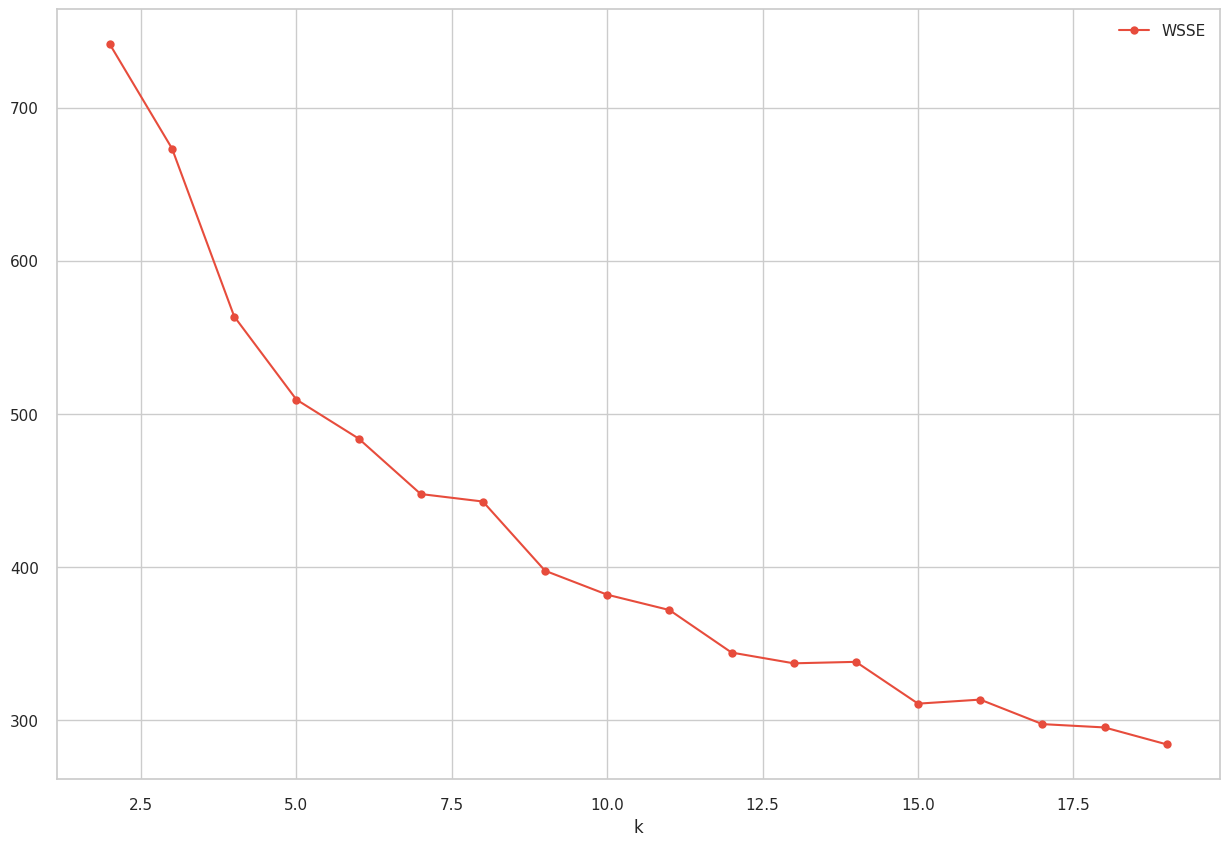

In [75]:
elbow_plot(wsseList, clusters)